In [77]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import os
from scipy.stats import describe, pearsonr

In [2]:
score_folder = './results/scores/'

In [5]:
ws_list = [1,2,3,5,7,10,12,200]
alpha_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
k_list = [1,1.5,2,3,4,5,6,8,10,15]

In [9]:
columns = ['window_size','alpha','k','rho','pvalue']
table = np.empty( ( len(ws_list)*len(alpha_list)*len(k_list) , len(columns)) )

In [16]:
i = 0
print('Records: {}'.format(table.shape[0]))
for ws in ws_list:
    for alpha in alpha_list:
        for k in k_list:
            file_name = f'count_ws{ws}/count_ws{ws}-ppmi_a{alpha}_k{k}'
            arr = np.genfromtxt(score_folder+file_name, delimiter='\t')
            if len(arr.shape)>1: #more than one line
                rho, pvalue = arr.mean(axis=0)
            else:
                rho, pvalue = arr
            table[i] = ( ws, alpha, k, rho, pvalue )
            i+=1
            print(f'\r{i}/{table.shape[0]}\t({np.round(i/table.shape[0]*100,2)}%)',end='')


Records: 800
800/800	(100.0%)

In [28]:
score_df = pd.DataFrame(table,columns=columns)
score_df['window_size'] = score_df['window_size'].astype('int16')
score_df

,window_size,alpha,k,rho,pvalue
0,1,0.1,1.0,0.03770,0.8247
1,1,0.1,1.5,0.02762,0.8711
2,1,0.1,2.0,0.00854,0.9600
3,1,0.1,3.0,0.01304,0.9389
4,1,0.1,4.0,0.01814,0.9151
...,...,...,...,...,...
795,200,1.0,5.0,0.19811,0.2398
796,200,1.0,6.0,0.19894,0.2378
797,200,1.0,8.0,0.17464,0.3012
798,200,1.0,10.0,0.18827,0.2644


In [72]:
grp_ws = score_df.groupby('window_size')
grp_a = score_df.groupby('alpha')
grp_k = score_df.groupby('k')


In [73]:
grp_ws_desc = grp_ws.rho.agg(['mean','std','var','min','max'])
grp_a_desc = grp_a.rho.agg(['mean','std','var','min','max'])
grp_k_desc = grp_k.rho.agg(['mean','std','var','min','max'])
grp_ws_desc

,mean,std,var,min,max
window_size,,,,,
1,0.052467,0.026028,0.000677,-0.00516,0.12722
2,0.168822,0.053454,0.002857,0.03569,0.24969
3,0.150867,0.033717,0.001137,0.07588,0.26486
5,0.191183,0.043175,0.001864,0.09888,0.28229
7,0.194971,0.048829,0.002384,0.06418,0.30601
10,0.219322,0.039636,0.001571,0.06436,0.30826
12,0.225321,0.036926,0.001364,0.11145,0.31940
200,0.229639,0.053975,0.002913,0.05751,0.33600


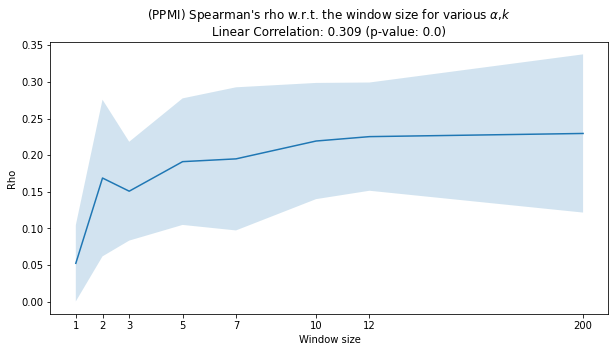

In [84]:
grp_ws_means = grp_ws_desc['mean']
grp_ws_error = 2*grp_ws_desc['std']
corr_r, corr_pvalue = pearsonr( score_df.window_size, score_df.rho )

ws_x = [1,2,3,5,7,10,12,20]

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(ws_x,grp_ws_means)
ax.fill_between(ws_x,grp_ws_means-grp_ws_error,grp_ws_means+grp_ws_error,alpha=0.2)
ax.set_xticks(ws_x)
ax.set_xticklabels(ws_list)
ax.set_title("(PPMI) Spearman's rho w.r.t. the window size for various $\\alpha$,$k$\nLinear Correlation: {} (p-value: {})".format(corr_r.round(3),corr_pvalue.round(5)))
ax.set_xlabel('Window size')
ax.set_ylabel('Rho')
plt.savefig('results_img/ws_rho.png',dpi=100,transparent=False)
plt.show()

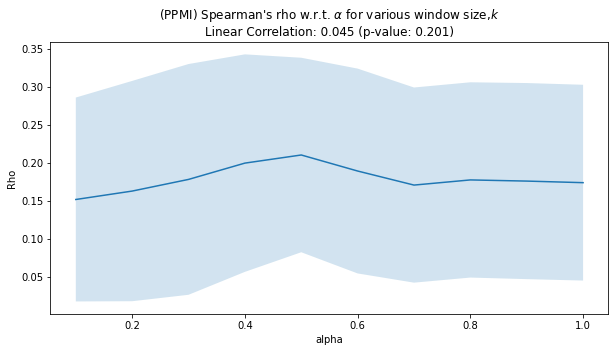

In [85]:
means = grp_a_desc['mean']
error = 2*grp_a_desc['std']
x = alpha_list
corr_r, corr_pvalue = pearsonr( score_df.alpha, score_df.rho )

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(x,means)
ax.fill_between(x,means-error,means+error,alpha=0.2)
ax.set_title("(PPMI) Spearman's rho w.r.t. $\\alpha$ for various window size,$k$\nLinear Correlation: {} (p-value: {})".format(corr_r.round(3),corr_pvalue.round(3)))
ax.set_xlabel('alpha')
ax.set_ylabel('Rho')
plt.savefig('results_img/alpha_rho.png',dpi=100,transparent=False)
plt.show()

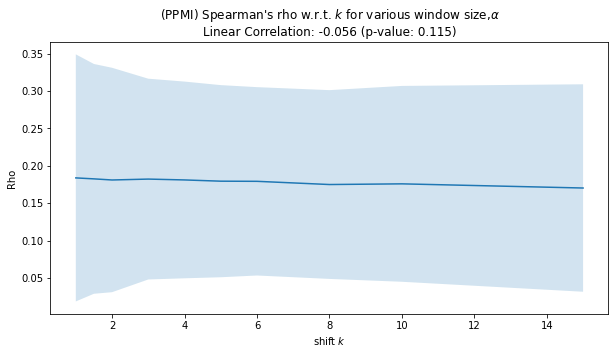

In [86]:
means = grp_k_desc['mean']
error = 2*grp_k_desc['std']
x = k_list
corr_r, corr_pvalue = pearsonr( score_df.k, score_df.rho )

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(x,means)
ax.fill_between(x,means-error,means+error,alpha=0.2)
ax.set_title("(PPMI) Spearman's rho w.r.t. $k$ for various window size,$\\alpha$\nLinear Correlation: {} (p-value: {})".format(corr_r.round(3),corr_pvalue.round(3)))
ax.set_xlabel('shift $k$')
ax.set_ylabel('Rho')
plt.savefig('results_img/k_rho.png',dpi=100,transparent=False)
plt.show()

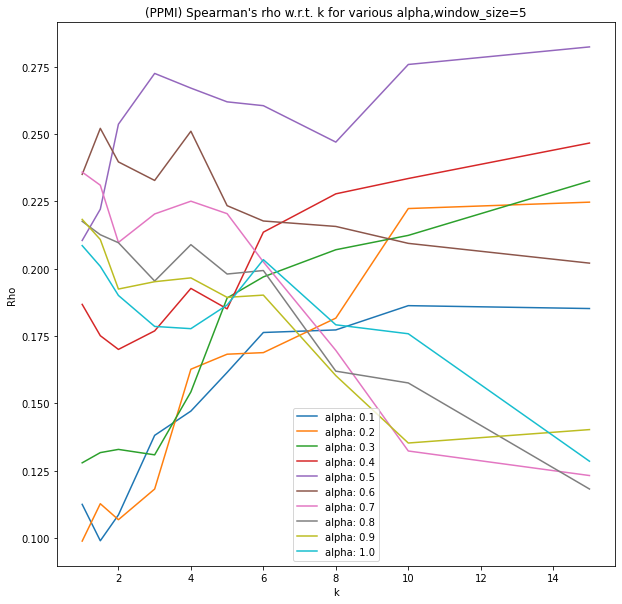

In [100]:
first_attribute = 'window_size'
first_value = 5
second_attribute = 'alpha'
third_attribute = 'k'
sub_range = alpha_list
last_range = k_list


group_df = score_df.groupby(first_attribute).get_group(first_value)
sub_groups = group_df.groupby(second_attribute)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

for subgroup_value in sub_range:
    subgroup = sub_groups.get_group(subgroup_value)
    y = subgroup.rho
    ax.plot(last_range,y,label=second_attribute+': '+str(subgroup_value))

ax.set_title("(PPMI) Spearman's rho w.r.t. {} for various {},{}={}".format(third_attribute,second_attribute,first_attribute,first_value))
ax.set_xlabel(third_attribute)
ax.set_ylabel('Rho')
plt.legend()
#plt.savefig('results_img/a_ws_rho.png',dpi=100,transparent=False)
plt.show()

In [ ]:
first_attribute = 'window_size'
first_values = 5
second_attribute = 'alpha'
third_attribute = 'k'
sub_range = alpha_list
last_range = k_list


group_df = score_df.groupby(first_attribute).get_group(first_value)
sub_groups = group_df.groupby(second_attribute)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

for subgroup_value in sub_range:
    subgroup = sub_groups.get_group(subgroup_value)
    y = subgroup.rho
    ax.plot(last_range,y,label=second_attribute+': '+str(subgroup_value))

ax.set_title("(PPMI) Spearman's rho w.r.t. {} for various {},{}={}".format(third_attribute,second_attribute,first_attribute,first_value))
ax.set_xlabel(third_attribute)
ax.set_ylabel('Rho')
plt.legend()
#plt.savefig('results_img/a_ws_rho.png',dpi=100,transparent=False)
plt.show()